In [1]:
import geopandas as gpd
import pandas as pd
import os
from collections import defaultdict

In [2]:
nuclei_path = "data/geojson_nuclei"
tissue_path = "data/geojson_tissue"

In [3]:
filename = "metastatic_roi_003_tissue.geojson"

img_id = "_".join(filename.split("_")[:-1])
img_id

'metastatic_roi_003'

#### Creazione delle funzioni

In [4]:
# FUNZIONE CHE CREA IL DIZIONARIO DELLE LABELS PARTENDO DAI GEOJSON NELLA CARTELLA SPECIFICA

### -- SELEZIONA LA CLASS_TYPE: METASTATIC | PRIMARY 

def extract_labels(folder_path, class_type: str):
    
    img_labels = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.geojson') & filename.startswith(class_type): #check sul formato e sulla classe dell'immagine
            filepath = os.path.join(folder_path, filename)
            # creazione del gdf
            gdf = gpd.read_file(filepath)
            gdf["name"] = gdf.classification.apply(lambda x: x.split(",")[0].replace('{ "name": ', "").strip('"'))
            
            labels = set(gdf.name.unique())
            
            img_id = "_".join(filename.split("_")[:-1])
            img_labels[img_id] = labels
            
    return img_labels
            

In [5]:
# FUNZIONE CHE CREA IL DATAFRAME PRENDENDO IN INGRESSO DUE DIZIONARI (TESSUTI E NUCLEI)

def dataframe_from_labels(tissue_labels: dict, nuclei_labels: dict, strict: bool = True):
    
    
    # Trova ID immagine e controlla che siano presenti nel dizionario dei nuclei e dei tessuti
    nuclei_ids = set(nuclei_labels.keys())
    tissue_ids = set(tissue_labels.keys())
    common_ids = nuclei_ids & tissue_ids

    if strict:
        only_in_nuclei = nuclei_ids - tissue_ids
        only_in_tissue = tissue_ids - nuclei_ids

        if only_in_nuclei or only_in_tissue:
            raise ValueError(
                f"Immagini non allineate!\n"
                f"Solo nei nuclei: {sorted(only_in_nuclei)}\n"
                f"Solo nei tessuti: {sorted(only_in_tissue)}"
            )

    # Usa solo le immagini comuni
    image_ids = sorted(common_ids)
    
    # Crea le classi dei nuclei e dei tessuti 
    NUCLEI_LABELS = sorted({lbl for s in nuclei_labels.values() for lbl in s})
    TISSUE_LABELS = sorted({lbl for s in tissue_labels.values() for lbl in s})
    
    # Costruisce i records
    records = []

    for img_id in image_ids:
        row = {"image_id": img_id}

        for lbl in NUCLEI_LABELS:
            row[f"nuclei_{lbl}"] = int(lbl in nuclei_labels.get(img_id, set()))

        for lbl in TISSUE_LABELS:
            row[f"tissue_{lbl}"] = int(lbl in tissue_labels.get(img_id, set()))

        records.append(row)

    # Costruisce il df
    df = pd.DataFrame.from_records(records)
    df.set_index("image_id", inplace=True)

    return df

#### Creazione dei DFs

In [6]:
# PARTE RELATIVA AI METASTATIC

metastatic_nuclei_labels = extract_labels(nuclei_path, 'metastatic')
metastatic_tissue_labels = extract_labels(tissue_path, 'metastatic')

metastatic_df = dataframe_from_labels(metastatic_tissue_labels, metastatic_nuclei_labels)

metastatic_df.head()

,nuclei_nuclei_apoptosis,nuclei_nuclei_endothelium,nuclei_nuclei_histiocyte,nuclei_nuclei_lymphocyte,nuclei_nuclei_melanophage,nuclei_nuclei_neutrophil,nuclei_nuclei_plasma_cell,nuclei_nuclei_stroma,nuclei_nuclei_tumor,tissue_tissue_blood_vessel,tissue_tissue_necrosis,tissue_tissue_stroma,tissue_tissue_tumor,tissue_tissue_white_background
image_id,,,,,,,,,,,,,,
metastatic_roi_001,1,1,0,1,0,0,0,0,1,0,1,0,1,0
metastatic_roi_002,0,1,0,1,0,0,1,1,1,1,0,1,1,0
metastatic_roi_003,0,1,0,1,0,0,0,1,1,1,0,1,1,0
metastatic_roi_004,1,1,0,1,0,0,0,0,1,0,0,0,1,0
metastatic_roi_005,1,1,1,1,0,0,0,1,1,1,0,1,1,0


In [7]:
# PARTE RELATIVA AI PRIMARY

primary_nuclei_labels = extract_labels(nuclei_path, 'primary')
primary_tissue_labels = extract_labels(tissue_path, 'primary')

primary_df = dataframe_from_labels(primary_tissue_labels, primary_nuclei_labels)

primary_df.head()

,nuclei_nuclei_apoptosis,nuclei_nuclei_endothelium,nuclei_nuclei_epithelium,nuclei_nuclei_histiocyte,nuclei_nuclei_lymphocyte,nuclei_nuclei_melanophage,nuclei_nuclei_neutrophil,nuclei_nuclei_plasma_cell,nuclei_nuclei_stroma,nuclei_nuclei_tumor,tissue_tissue_blood_vessel,tissue_tissue_epidermis,tissue_tissue_necrosis,tissue_tissue_stroma,tissue_tissue_tumor,tissue_tissue_white_background
image_id,,,,,,,,,,,,,,,,
primary_roi_001,1,1,0,1,1,1,0,0,1,1,1,0,0,1,1,0
primary_roi_002,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0
primary_roi_003,0,1,0,1,1,0,0,1,1,1,1,0,0,1,1,0
primary_roi_004,0,1,1,1,1,0,0,0,1,1,1,1,0,1,1,0
primary_roi_005,0,1,0,1,1,1,0,0,1,1,1,0,0,1,1,0


#### Creazione dello split

In [8]:
from skmultilearn.model_selection import iterative_train_test_split
import matplotlib.pyplot as plt

In [19]:
def split_creation(df, t_size: float ):

    # Convertiamo in matrici numpy
    X = df.index.to_numpy().reshape(-1, 1)  # solo gli ID
    y = df.to_numpy().astype(int)     # multilabel binaria

    # Split multilabel stratificato 90/10
    X_train, y_train, X_val, y_val = iterative_train_test_split(X, y, test_size=t_size)

    # Ritorna array di ID — convertiamoli in liste
    train_ids = [x[0] for x in X_train]
    val_ids = [x[0] for x in X_val]
    
    df_train = df.loc[train_ids]
    df_val = df.loc[val_ids]
    
    return df_train, df_val
    

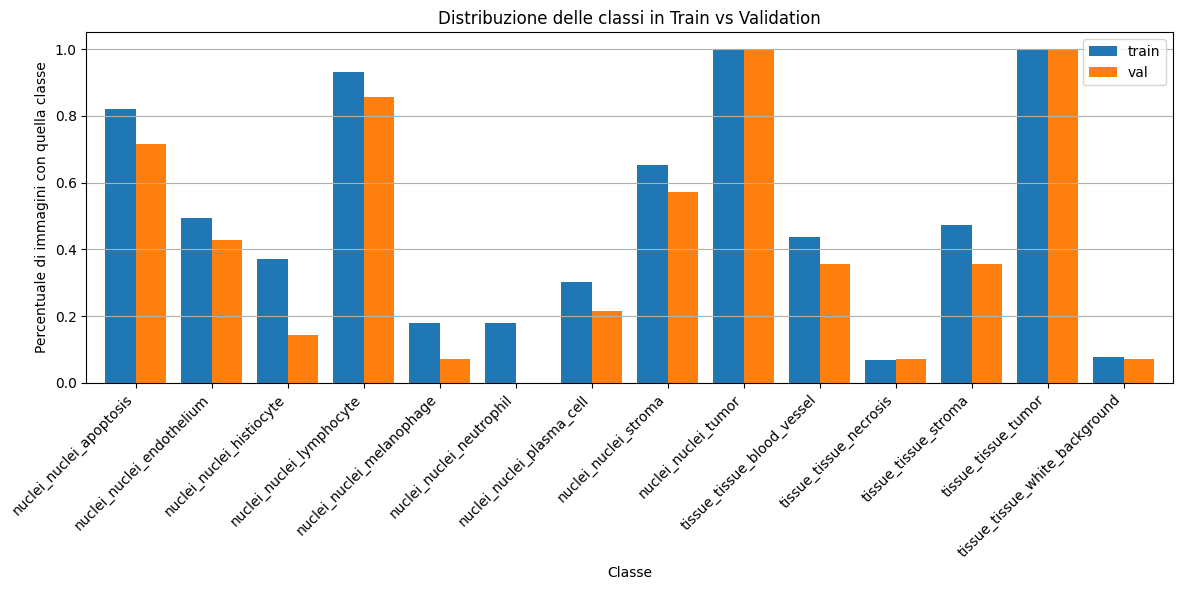

In [28]:
# ESECUZIONE PER IL METASTATIC

met_df_train, met_df_val  = split_creation(metastatic_df, 0.1)

# Crea un DataFrame per il plot
class_distribution = pd.DataFrame({
    'train': (met_df_train.sum() / len(met_df_train)).sort_index(), 
    'val': (met_df_val.sum() / len(met_df_val)).sort_index()
})

# Plot
ax = class_distribution.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Distribuzione delle classi in Train vs Validation')
plt.xlabel('Classe')
plt.ylabel('Percentuale di immagini con quella classe')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

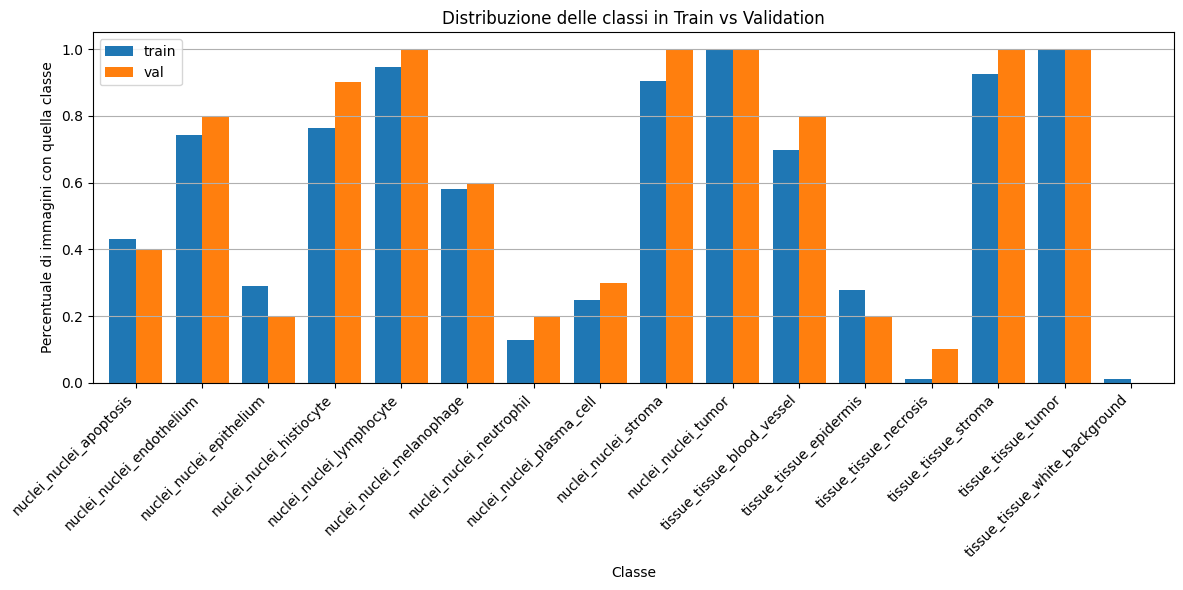

In [29]:
# ESECUZIONE PER IL PRIMARY
pri_df_train, pri_df_val  = split_creation(primary_df, 0.1)

# Crea un DataFrame per il plot
class_distribution = pd.DataFrame({
    'train': (pri_df_train.sum() / len(pri_df_train)).sort_index(), 
    'val': (pri_df_val.sum() / len(pri_df_val)).sort_index()
})

# Plot
ax = class_distribution.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Distribuzione delle classi in Train vs Validation')
plt.xlabel('Classe')
plt.ylabel('Percentuale di immagini con quella classe')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [26]:
print("Metastatic: train=", len(met_df_train), ", val=", len(met_df_val))
print("Primary: train=", len(pri_df_train), ", val=", len(pri_df_val))

print("Totale: train=", len(met_df_train) + len(pri_df_train), ", val=", len(met_df_val) + len(pri_df_val))

print("Totale immagini: ", len(met_df_train) + len(met_df_val) + len(pri_df_train) + len(pri_df_val))

Metastatic: train= 89 , val= 14
Primary: train= 93 , val= 10
Totale: train= 182 , val= 24
Totale immagini:  206


In [12]:
# MERGE DI TRAIN E VAL + CREAZIONE DEL TXT FINALE

complete_train_df = pd.concat([met_df_train, pri_df_train], axis=0)
complete_train_df

,nuclei_nuclei_apoptosis,nuclei_nuclei_endothelium,nuclei_nuclei_histiocyte,nuclei_nuclei_lymphocyte,nuclei_nuclei_melanophage,nuclei_nuclei_neutrophil,nuclei_nuclei_plasma_cell,nuclei_nuclei_stroma,nuclei_nuclei_tumor,tissue_tissue_blood_vessel,tissue_tissue_necrosis,tissue_tissue_stroma,tissue_tissue_tumor,tissue_tissue_white_background,nuclei_nuclei_epithelium,tissue_tissue_epidermis
image_id,,,,,,,,,,,,,,,,
metastatic_roi_003,0,1,0,1,0,0,0,1,1,1,0,1,1,0,NaN,NaN
metastatic_roi_004,1,1,0,1,0,0,0,0,1,0,0,0,1,0,NaN,NaN
metastatic_roi_007,0,1,1,1,0,0,1,1,1,1,0,1,1,0,NaN,NaN
metastatic_roi_008,1,0,0,1,0,0,0,0,1,0,1,0,1,1,NaN,NaN
metastatic_roi_010,1,0,1,1,0,0,0,1,1,0,0,1,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
primary_roi_098,0,1,1,1,1,0,1,1,1,1,0,1,1,0,0.0,0.0
primary_roi_100,0,0,1,1,1,0,1,1,1,0,0,1,1,0,1.0,1.0
primary_roi_101,1,1,1,1,1,0,0,1,1,1,0,1,1,0,1.0,1.0


In [27]:
complete_val_df = pd.concat([met_df_val, pri_df_val], axis=0)
complete_val_df

,nuclei_nuclei_apoptosis,nuclei_nuclei_endothelium,nuclei_nuclei_histiocyte,nuclei_nuclei_lymphocyte,nuclei_nuclei_melanophage,nuclei_nuclei_neutrophil,nuclei_nuclei_plasma_cell,nuclei_nuclei_stroma,nuclei_nuclei_tumor,tissue_tissue_blood_vessel,tissue_tissue_necrosis,tissue_tissue_stroma,tissue_tissue_tumor,tissue_tissue_white_background,nuclei_nuclei_epithelium,tissue_tissue_epidermis
image_id,,,,,,,,,,,,,,,,
metastatic_roi_001,1,1,0,1,0,0,0,0,1,0,1,0,1,0,NaN,NaN
metastatic_roi_002,0,1,0,1,0,0,1,1,1,1,0,1,1,0,NaN,NaN
metastatic_roi_005,1,1,1,1,0,0,0,1,1,1,0,1,1,0,NaN,NaN
metastatic_roi_006,1,0,0,1,0,0,0,1,1,0,0,1,1,0,NaN,NaN
metastatic_roi_009,1,0,0,1,0,0,0,0,1,0,0,0,1,0,NaN,NaN
metastatic_roi_012,1,0,0,1,0,0,0,0,1,0,0,0,1,0,NaN,NaN
metastatic_roi_013,1,1,0,1,0,0,0,0,1,1,0,0,1,0,NaN,NaN
metastatic_roi_017,1,0,0,1,0,0,1,0,1,0,0,0,1,0,NaN,NaN
metastatic_roi_019,1,0,0,0,0,0,0,1,1,0,0,1,1,0,NaN,NaN


In [30]:
complete_train_df.index.to_series().to_csv("train_ids.txt", index=False, header=False)
complete_val_df.index.to_series().to_csv("val_ids.txt", index=False, header=False)